IMPORT ALL NECESSARY LIBRARY

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
from textblob import TextBlob
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from wordcloud import WordCloud
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

In [2]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/carsell/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/carsell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/carsell/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/carsell/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
# Create a lemmatizer object
lemmatizer = nltk.stem.WordNetLemmatizer()

In [4]:
# Function to map POS tag to first character lemmatize() accepts
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return nltk.corpus.wordnet.NOUN

LOAD THE DATA AND VIEW THE FIRST 5 ROWS

In [5]:
data = pd.read_csv('CyberBullying Comments Dataset.csv')
data.head()

,Text,CB_Label
0,damn there is someones nana up here at beach w...,0
1,no kidding! dick clark was a corpse mechanical...,0
2,i read an article on jobros and thought damn w...,0
3,I got one fucking day of sprinkles and now it'...,0
4,I was already listening to Elliott smith and ...,0


GET INFO ABOUT THE DATASET

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11100 entries, 0 to 11099
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      11100 non-null  object
 1   CB_Label  11100 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 173.6+ KB


CHECK FOR NAN VALUES

In [7]:
data.isnull().sum()

Text        0
CB_Label    0
dtype: int64

DATA PREPROCESSING

In [8]:
# Preprocess the text data
stop_words = set(stopwords.words('english'))

In [9]:
def preprocess_text(text):
    # Remove special characters and convert to lowercase
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

data['Text'] = data['Text'].apply(preprocess_text)
data.head()

,Text,CB_Label
0,damn someones nana beach one dont think ic ste...,0
1,kidding dick clark corpse mechanically operate...,0
2,read article jobros thought damn cash jobro po...,0
3,got one fucking day sprinkles back sunshine do...,0
4,already listening elliott smith fucking hate k...,0


In [10]:
# Apply lemmatization to the 'Text' column
def lemmatize_text(text):
    tokens = nltk.word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos=get_wordnet_pos(tag))
                         for token, tag in nltk.pos_tag(tokens)]
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text

data['Text'] = data['Text'].apply(preprocess_text)
data['Text'] = data['Text'].apply(lemmatize_text)

In [11]:
# Remove any unwanted characters or symbols from the text
data['Text'] = data['Text'].str.replace('[^a-zA-Z]', ' ')
data.head()

,Text,CB_Label
0,damn someone nana beach one dont think ic stea...,0
1,kid dick clark corpse mechanically operate adv...,0
2,read article jobros think damn cash jobro poke...,0
3,get one fucking day sprinkle back sunshine dou...,0
4,already listen elliott smith fuck hate kanye w...,0


In [12]:
#Transform text into word matrix
count_vectorizer = CountVectorizer()
count_matrix = count_vectorizer.fit_transform(data['Text'])
count_matrix

<11100x15346 sparse matrix of type '<class 'numpy.int64'>'
	with 94221 stored elements in Compressed Sparse Row format>

PROCEED WITH TEXT MINING

In [13]:
# Feature selection
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['Text'])
y = data['CB_Label']

In [14]:
#Extract unique words from text data
count_vocab = count_vectorizer.get_feature_names_out()
tfidf_vocab = vectorizer.get_feature_names_out()

In [15]:
#Create dictionary to map words to their frequencies
count_word_freq = count_matrix.sum(axis=0)
word_freq_dict = dict(zip(count_vocab, count_word_freq.A1))

In [16]:
#Obtain list of words along with their average TF-IDF scores
tfidf_word_scores = zip(tfidf_vocab, count_matrix.toarray().mean(axis=0))
tfidf_word_scores = sorted(tfidf_word_scores, key=lambda x: x[1], reverse=True)

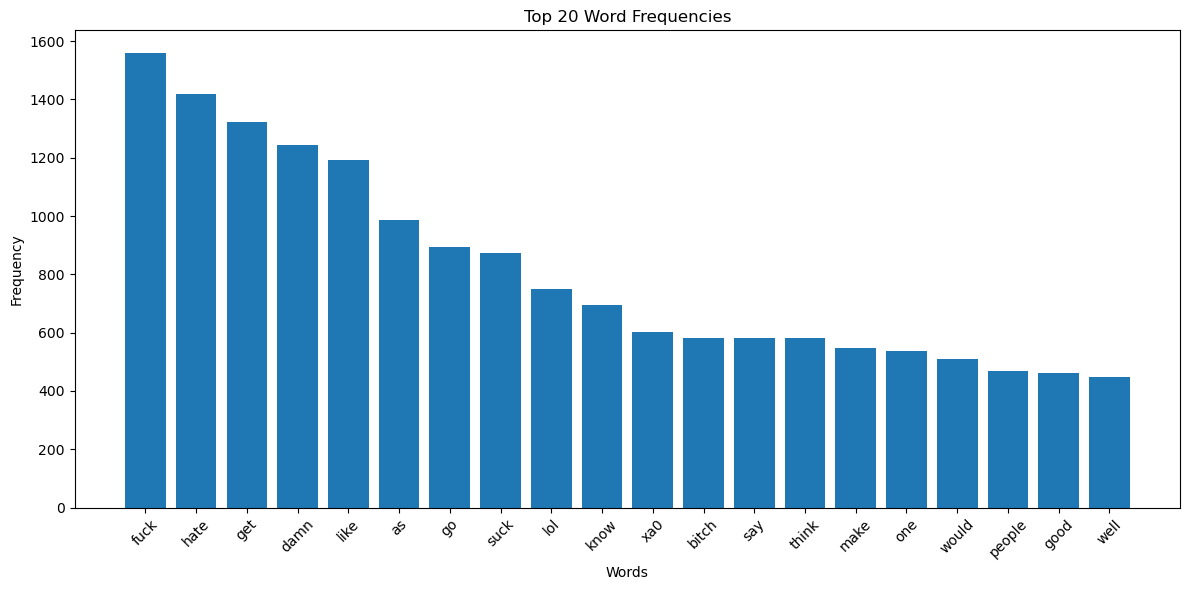

In [17]:
# Plotting word frequencies
top_words = 20  # Number of top words to plot
top_words_freq = sorted(word_freq_dict.items(), key=lambda x: x[1], reverse=True)[:top_words]
words, frequencies = zip(*top_words_freq)

plt.figure(figsize=(12, 6))
plt.bar(words, frequencies)
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top {} Word Frequencies'.format(top_words))
plt.tight_layout()
plt.show()

PROCEED TO SENTIMENT ANALYSIS

In [18]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
#Check if y_train class labels are balanced
y_train.value_counts()

CB_Label
1    4458
0    4422
Name: count, dtype: int64

In [20]:
# Train a Random Forest classifier
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

RandomForestClassifier()

In [21]:
# Predict labels for the testing set
y_pred = classifier.predict(X_test)

In [22]:
# Evaluate the performance of the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
classification_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print('Classification_report:')
print(classification_report)

Accuracy: 0.7346846846846847
Precision: 0.7894131185270425
Recall: 0.6282051282051282
F1-score: 0.6996430392656807
Classification_report:
              precision    recall  f1-score   support

           0       0.70      0.84      0.76      1128
           1       0.79      0.63      0.70      1092

    accuracy                           0.73      2220
   macro avg       0.74      0.73      0.73      2220
weighted avg       0.74      0.73      0.73      2220



In [23]:
# Visualize the data using wordcloud
cyberbullying_words = ' '.join(data[data['CB_Label'] == 1]['Text'])
non_cyberbullying_words = ' '.join(data[data['CB_Label'] == 0]['Text'])

cyberbullying_wordcloud = WordCloud(width=800, height=400).generate(cyberbullying_words)
non_cyberbullying_wordcloud = WordCloud(width=800, height=400).generate(non_cyberbullying_words)

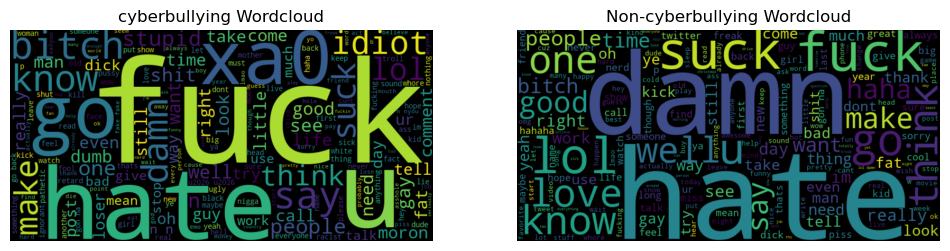

In [24]:
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.imshow(cyberbullying_wordcloud, interpolation='bilinear')
plt.title('cyberbullying Wordcloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(non_cyberbullying_wordcloud, interpolation='bilinear')
plt.title('Non-cyberbullying Wordcloud')
plt.axis('off')

plt.show()

In [25]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/carsell/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [26]:
# Perform sentiment analysis on each text sample
sentiments = []
for text in data['Text']:
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    sentiments.append(sentiment)
    
# Add the sentiment scores to the dataframe
data['Sentiment'] = sentiments

# Classify the sentiments based on a threshold
#(e.g., positive if sentiment > 0, negative if sentiment < 0, neutral otherwise)
data['Sentiment_Label'] = data['Sentiment'].apply(lambda x: 'positive' if x > 0 
                                                  else 'negative' if x < 0 else 'neutral')
# Print the resulting dataframe with sentiment labels
print(data[['Text', 'Sentiment_Label']])

                                                    Text Sentiment_Label
0      damn someone nana beach one dont think ic stea...        positive
1      kid dick clark corpse mechanically operate adv...         neutral
2      read article jobros think damn cash jobro poke...        positive
3      get one fucking day sprinkle back sunshine dou...        negative
4      already listen elliott smith fuck hate kanye w...        negative
...                                                  ...             ...
11095  worry little empty head go back wipe as hula hoop        negative
11096  ya dumb fuck strategic move 50 get blacklist g...        negative
11097  lana full shit eye brown xa0 n nno green xa0li...        negative
11098  lie let dbeeio61 disqus xa0 xa0 nigga tell mot...         neutral
11099  look like little cut n paste job gotten little...        negative

[11100 rows x 2 columns]


In [27]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Convert text data to document-term matrix
vectorizer = CountVectorizer()
dtm = vectorizer.fit_transform(data['Text'])

# Apply LDA to extract topics
lda_model = LatentDirichletAllocation(n_components=3)  # Specify the number of topics
lda_model.fit(dtm)

# Get the most probable words for each topic
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]
    print(f"Topic {topic_idx+1}: ", top_words)

Topic 1:  ['fuck', 'damn', 'like', 'get', 'go', 'bitch', 'as', 'lol', 'know', 'shit']
Topic 2:  ['hate', 'suck', 'go', 'lol', 'like', 'damn', 'make', 'get', 'good', 'people']
Topic 3:  ['get', 'as', 'think', 'like', 'haha', 'fat', 'hate', 'know', 'xa0', 'gay']
